# Rental Location EDA
## *** Steps
#### 0) Data load & preprocess
     - 0-1) load the data 
     - 0-1) feature engineering
#### 1) Data overview
#### 2) Variables relations 
        -2-1) Variable scatter plots
        -2-2) Geo data visualization
#### 3) Clustering 
#### 4) Oberservation
> * Most of the rental in this dataset are UK<---> UK (2377 over 2500 total rental orders ).
* Most of the distance between borrower and lender are < 20 KM,
 since most of the rental are within UK city 
* Except UK <--> UK, there are some interesting rental between FR <--> UK,
US <---> UK for example. It's interesting to take a look how people 
complete the rental when they are so far away with each other 
* For UK rental, Most of the lenders are in the center of UK city 
  while many borrowers are outside the UK city, one of the explainable reason is : most UK city people are rich and have idle stuff to lend
  that make they are much active lenders
* Run a simple clustering (KMeans) to classify borrower into groups 
with their locations. This trick can be done to set up user groups 
for customized services and other user engagement following up.
  
 
  

In [1]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt
import folium
from folium import plugins
from mpl_toolkits.basemap import Basemap
import reverse_geocode 


# set plot style
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

Populating the interactive namespace from numpy and matplotlib


## 0) Data load & preprocess

In [2]:
# help func

# -----------------------
# feature engineering 

def get_haversine_distance(lat1, lng1, lat2, lng2):
    # km
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  #  km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


def get_manhattan_distance(lat1, lng1, lat2, lng2):
    # km 
    a = get_haversine_distance(lat1, lng1, lat1, lng2)
    b = get_haversine_distance(lat1, lng1, lat2, lng1)
    return a + b




def plot_heatmap_lon_lat(df,lat,lon,map_center):
    #map_center = [50.87650,4.39723]
    print (map_center)
    heatmap = folium.Map(location=map_center, 
                         tiles='https://api.tiles.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiZ29nb3ZhbmFwcCIsImEiOiJjaWg3MTk0ZjAwZmI5dXVraTF5aDNudTd0In0.mcuRTlI-EWoMm0IponVnVA',
                         attr='Map data &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors, <a href="http://creativecommons.org/licenses/by-sa/2.0/">CC-BY-SA</a>, Imagery © <a href="http://mapbox.com">Mapbox</a>',
                         zoom_start=11)

    # plz modify lon / lat columns here in cases for various dataset 
    heatmap_locations_list = df[[lat, lon]].dropna().values.tolist()
    heatmap.add_children(plugins.HeatMap(heatmap_locations_list, radius=20, blur=30))
    display(heatmap)

    
def get_country_lon_lat(lon,lat):
    pass
    
# -----------------------


In [3]:
df=pd.read_csv('DemoLondonRentals.csv')
df.columns=['id','borrower_lat','borrower_lng','lender_lat','lender_lng']

In [4]:
# get distance 
df.loc[:, 'distance_manhattan'] = get_manhattan_distance(
                                  df['borrower_lat'].values,
                                  df['borrower_lng'].values,
                                  df['lender_lat'].values,
                                  df['lender_lng'].values)

df.loc[:, 'distance_haversine'] = get_haversine_distance(
                                  df['borrower_lat'].values,
                                  df['borrower_lng'].values,
                                  df['lender_lat'].values,
                                  df['lender_lng'].values)


# get borrower country 
coordinates=[i for i in list(zip( df.borrower_lat, df.borrower_lng))]
revere_results=reverse_geocode.search(coordinates)
country_list=[m['country'] for m in revere_results]
city_list=[m['city'] for m in revere_results]
df['borrower_country'] = country_list
df['borrower_city'] = city_list
# get lender country 
coordinates2=[i for i in list(zip( df.lender_lat, df.lender_lng))]
revere_results2=reverse_geocode.search(coordinates2)
country_list2=[m['country'] for m in revere_results2]
city_list2=[m['city'] for m in revere_results2]
df['lender_country'] = country_list2
df['lender_city'] = city_list2


## 1) Data overview

In [5]:
df.head(3)

,id,borrower_lat,borrower_lng,lender_lat,lender_lng,distance_manhattan,distance_haversine,borrower_country,borrower_city,lender_country,lender_city
0,1,51.370,-0.0250,51.524,-0.3180,37.463402,26.561818,United Kingdom,West Wickham,United Kingdom,Wembley
1,2,51.397,-0.1160,51.421,-0.1770,6.900663,5.002213,United Kingdom,South Croydon,United Kingdom,Mitcham
2,3,51.515,0.0193,51.493,0.0602,5.276474,3.741409,United Kingdom,Poplar,United Kingdom,Barking


(-1, 50)

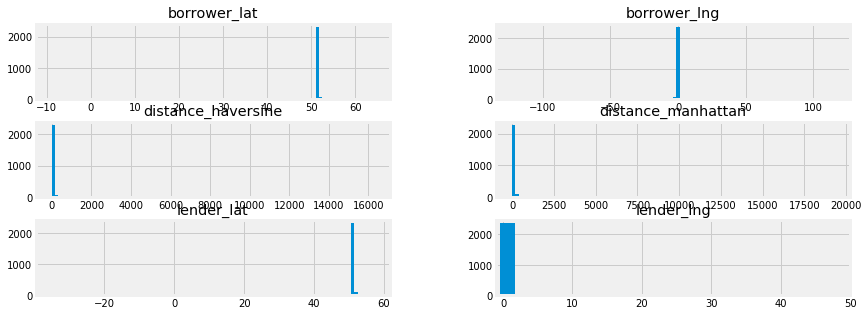

In [6]:
# hist of all cols 
df.iloc[:,1:].hist(bins=100,figsize=(13,5))
plt.xlim(-1,50)

Text(0.5,0,'distance_manhattan')

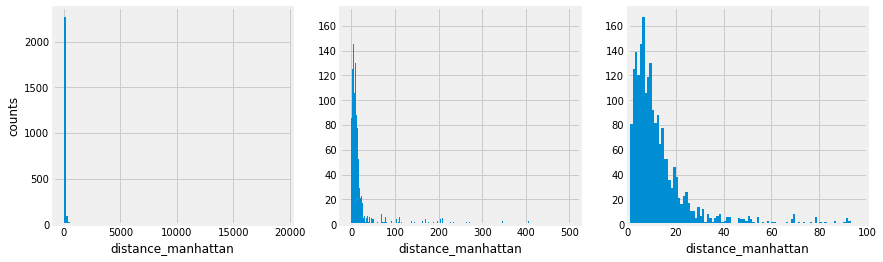

In [7]:
# distance histgram (distance_manhattan)



# make sure the ranges we chose are sensible
fig, axArray = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
# hist for all range 
axArray[0].hist(df['distance_manhattan'],100); 
axArray[0].set_xlabel('distance_manhattan')
axArray[0].set_ylabel('counts')
# hist form 0 - 500
axArray[1].hist(df['distance_manhattan'] ,bins=range(0, 500))
plt.xlim(0,500)
axArray[1].set_xlabel('distance_manhattan')
# hist from 0 - 100 
axArray[2].hist(df['distance_manhattan'],bins=range(0, 100))
plt.xlim(0,100)
axArray[2].set_xlabel('distance_manhattan')



/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


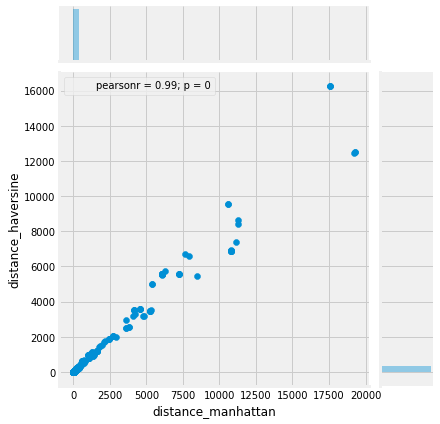

In [8]:
# manhattan VS haversine distance

sns.jointplot(x="distance_manhattan", y="distance_haversine",data=df)

### Distance feature
> Most of the distance between borrower and lender are < 20 KM 
which make sense since most of the rental are within UK <---> UK; 
However, some distance are with long distance ( > 100 KM)
It's interesting take a look where the borrower/lender in these
orders from

>There are 2 ways calculate distance : manhattan and haversine.
From this regression plot we can see the 2 ways work similiar for most of the data points


In [9]:
# borrower_country VS lender_country

top_country= df.borrower_country.value_counts().head(20).index

df_country=df[(df.borrower_country.isin(top_country)) &
              (df.lender_country.isin(top_country))]
b_l_country_count= df_country.groupby(['borrower_country','lender_country']).count()['id'].reset_index()
country_count_pivot=  pd.pivot_table(b_l_country_count,columns=['borrower_country'],index=['lender_country']).fillna(0)
country_count_pivot

id                                                   \
borrower_country Cyprus Dominican Republic France Germany Greece Iceland   
lender_country                                                             
Cyprus              0.0                0.0    0.0     0.0    0.0     0.0   
France              0.0                0.0    0.0     0.0    0.0     0.0   
Germany             0.0                0.0    0.0     0.0    0.0     0.0   
India               0.0                0.0    0.0     0.0    0.0     0.0   
Ireland             0.0                0.0    0.0     0.0    0.0     0.0   
Turkey              0.0                0.0    0.0     0.0    0.0     0.0   
United Kingdom      2.0                9.0    2.0     9.0    2.0     3.0   
United States       0.0                0.0    0.0     0.0    0.0     0.0   

                                                                           \
borrower_country India Indonesia Ireland Italy Latvia Lebanon Netherlands   
lender_country                                                              
Cyprus             0.0       0.0     0.0   0.0    0.0     0.0         0.0   
France             0.0       0.0     0.0   0.0    0.0     0.0         0.0   
Germany            0.0       0.0     0.0   0.0    0.0     0.0         0.0   
India              0.0       0.0     0.0   0.0    0.0     0.0         0.0   
Ireland            0.0       0.0     0.0   0.0    0.0     0.0         0.0   
Turkey             0.0       0.0     0.0   0.0    0.0     0.0         0.0   
United Kingdom     1.0       3.0     1.0   4.0    1.0     7.0         3.0   
United States      0.0       0.0     0.0   0.0    0.0     0.0         0.0   

                                                                           \
borrower_country Nigeria Spain Turkey United Arab Emirates United Kingdom   
lender_country                                                              
Cyprus               0.0   0.0    0.0                  0.0            2.0   
France               0.0   0.0    0.0                  0.0           16.0   
Germany              0.0   0.0    0.0                  0.0            2.0   
India                0.0   0.0    0.0                  0.0            1.0   
Ireland              0.0   0.0    0.0                  0.0            1.0   
Turkey               0.0   0.0    0.0                  0.0            1.0   
United Kingdom       2.0   4.0    2.0                  1.0         2377.0   
United States        0.0   0.0    0.0                  0.0           13.0   

                                
borrower_country United States  
lender_country                  
Cyprus                     0.0  
France                     0.0  
Germany                    0.0  
India                      0.0  
Ireland                    0.0  
Turkey                     0.0  
United Kingdom             6.0  
United States              0.0

### Country feature
> Again, in this table you can see most of the rental are within
UK <---> UK (2377 over 2500 total rental orders ).
It's valuable to check why most of the rental are within UK
while some rental are in the other EU countries


## 2 Variables relations 

### 2-1) Variable scatter plots


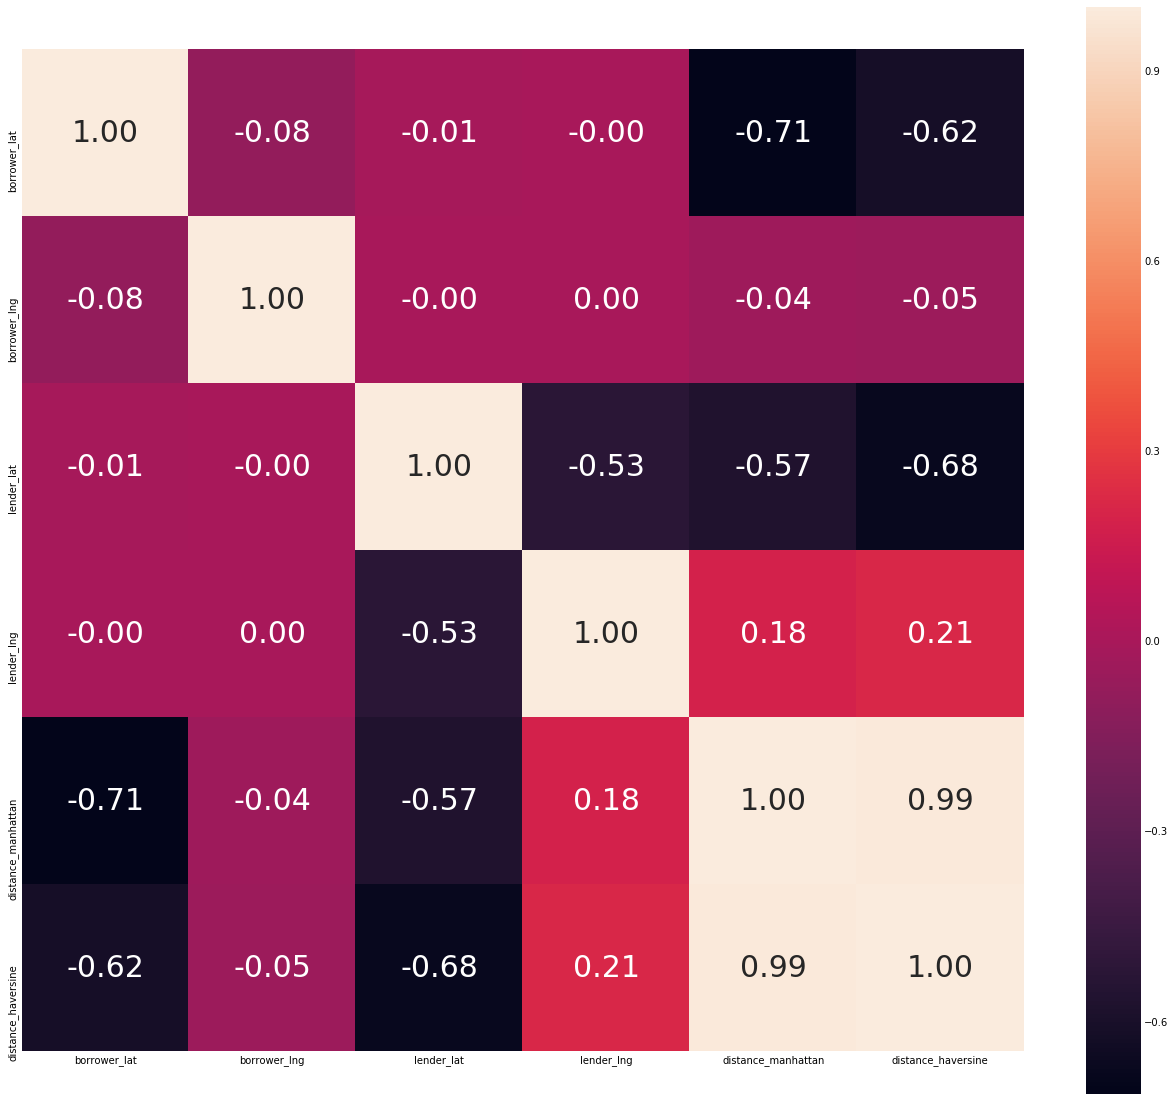

In [10]:
# heat map of correlation within cols 


cm = np.corrcoef(df.iloc[:,1:-4].values.T)
cols = df.iloc[:,1:-4].columns

# df.iloc[:,1:].corr()
plt.figure(figsize=(20,20))
#sns.set(font_scale=5)
hm = sns.heatmap( cm, 
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':30},
                yticklabels=cols,
                xticklabels=cols, 
            
                )
plt.show()

### correlation within cols 
>Can't find the columns/variables are with strong correlation
which make sense since all the columns from data source don't have 
direct relationship within each other 

### 2-2) Geo data visualization

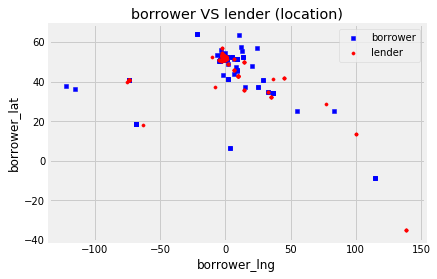

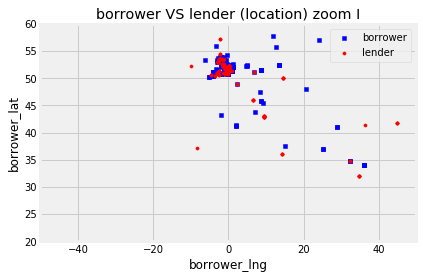

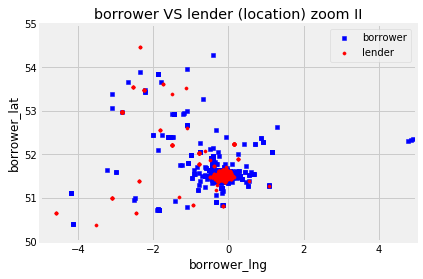

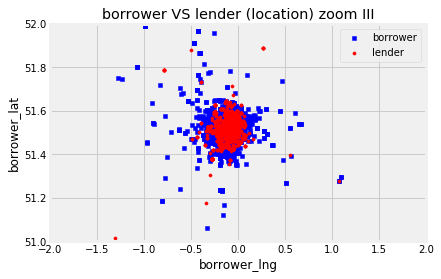

In [30]:
# visualize borrower & lender 


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.array(df.borrower_lng), np.array(df.borrower_lat), s=10, c='b', marker="s", label='first')
ax1.scatter(np.array(df.lender_lng), np.array(df.lender_lat), s=10, c='r', marker="o", label='second')
plt.legend(['borrower','lender'])
plt.xlabel('borrower_lng')
plt.ylabel('borrower_lat')
plt.title('borrower VS lender (location)')
plt.show()



fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.array(df.borrower_lng), np.array(df.borrower_lat), s=10, c='b', marker="s", label='first')
ax1.scatter(np.array(df.lender_lng), np.array(df.lender_lat), s=10, c='r', marker="o", label='second')
plt.xlim(-50,50)
plt.ylim(20,60)
plt.xlabel('borrower_lng')
plt.ylabel('borrower_lat')
plt.legend(['borrower','lender'])
plt.title('borrower VS lender (location) zoom I')
plt.show()




fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.array(df.borrower_lng), np.array(df.borrower_lat), s=10, c='b', marker="s", label='first')
ax1.scatter(np.array(df.lender_lng), np.array(df.lender_lat), s=10, c='r', marker="o", label='second')
plt.xlim(-5,5)
plt.ylim(50,55)
plt.xlabel('borrower_lng')
plt.ylabel('borrower_lat')
plt.legend(['borrower','lender'])
plt.title('borrower VS lender (location) zoom II')
plt.show()




fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.array(df.borrower_lng), np.array(df.borrower_lat), s=10, c='b', marker="s", label='first')
ax1.scatter(np.array(df.lender_lng), np.array(df.lender_lat), s=10, c='r', marker="o", label='second')
plt.xlim(-2,2)
plt.ylim(51,52)
plt.xlabel('borrower_lng')
plt.ylabel('borrower_lat')
plt.legend(['borrower','lender'])
plt.title('borrower VS lender (location) zoom III')
plt.show()

###  Borrower - Lender geo-location visualiztion
> Here we use 4 different scale plot the same Borrower - Lender location data, and get some very interesting find outs 

> 1) For #1 and #2 plots you can see that most of the rental
condense within UK; while some others are in other EU countries 

> 2) For #3 and #4 plots show that **most of the UK lenders are in fact 
locate in the city center** ; **many of the UK borrower are outside of the city**. One way to explain this  is : **most of the city people 
are rich / have some idle stuff / are willing to share, so that 
make they are active in lending stuff than other ones**

In [12]:
# borrower heatmap 
#plot_heatmap_lon_lat(df,'borrower_lat','borrower_lng',[51.370,-0.025])
# lender heatmap 
#plot_heatmap_lon_lat(df,'lender_lat','lender_lng',[51.524,-0.3180])

## 3) Clustering 

In [13]:
df.head(3)

,id,borrower_lat,borrower_lng,lender_lat,lender_lng,distance_manhattan,distance_haversine,borrower_country,borrower_city,lender_country,lender_city
0,1,51.370,-0.0250,51.524,-0.3180,37.463402,26.561818,United Kingdom,West Wickham,United Kingdom,Wembley
1,2,51.397,-0.1160,51.421,-0.1770,6.900663,5.002213,United Kingdom,South Croydon,United Kingdom,Mitcham
2,3,51.515,0.0193,51.493,0.0602,5.276474,3.741409,United Kingdom,Poplar,United Kingdom,Barking


In [23]:
from sklearn.cluster import MiniBatchKMeans
# get lon & lat clustering for following avg location speed calculation
def get_clustering(df):
    coords = np.vstack((df[['borrower_lat', 'borrower_lng']].values,
                    df[['lender_lat', 'lender_lng']].values))
    df_ = df.copy()
    kmeans = MiniBatchKMeans(n_clusters=10).fit(coords)
    df_.loc[:, 'borrower_cluster'] = kmeans.predict(df_[['borrower_lat', 'borrower_lng']])
    df_.loc[:, 'lender_cluster'] = kmeans.predict(df_[['lender_lat', 'lender_lng']])
    # a little bit modify clustering function here 
    return df_,kmeans

In [24]:
df_,kmeans = get_clustering(df)

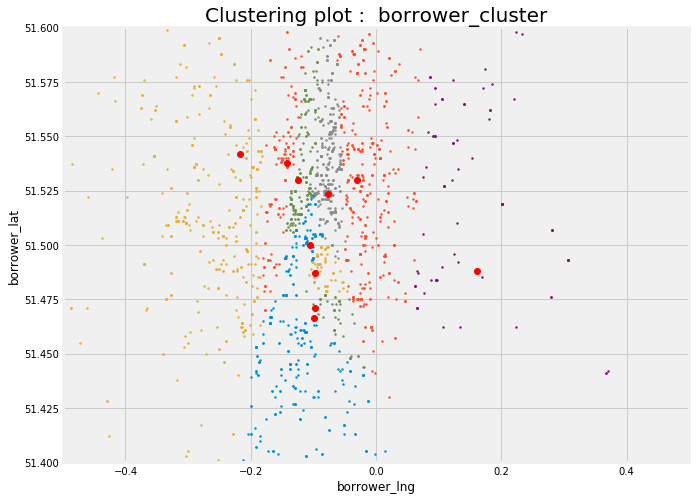

In [29]:
fig,ax = plt.subplots(figsize = (10,8))
for label in df_.borrower_cluster.unique():
    ax.plot(df_.borrower_lng[df_.borrower_cluster == label],df_.borrower_lat[df_.borrower_cluster == label],'.', alpha = 0.9, markersize = 3)
    ax.plot(kmeans.cluster_centers_[label,1],kmeans.cluster_centers_[label,0],'o', color = 'r')
    #ax.annotate(label, (kmeans.cluster_centers_[label,1],kmeans.cluster_centers_[label,0]), color = 'black', fontsize = 10)

plt.title('Clustering plot :  borrower_cluster',fontsize=20)
#plt.legend(list(set(df_.borrower_cluster)))
plt.xlabel('borrower_lng')
plt.ylabel('borrower_lat')
plt.xlim(-.5,.5)
plt.ylim(51.4,51.6)
plt.show()

###  Clustering
> Use simple KMeans model doing a clustering on borrower locations
from the plot above you can see that the locations be seperated into 
10 groups with distance between them and the center of groups 
>
Can tune the number of cluster to get the best fit group numbers 
and re-run this model again. one of the potential applications is 
classify borrower into groups and offer customized services based on 
their user groups 

In [18]:
# end of EDA 